In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import combinations
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import davies_bouldin_score, silhouette_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def scale_data(df: pd.DataFrame, scaler=MinMaxScaler, **kwargs):
    df = df.copy()
    scaler = scaler(**kwargs)
    column_names = df.columns
    scaled_data = scaler.fit_transform(df)
    new_df = pd.DataFrame(scaled_data, columns=column_names)
    return new_df

In [3]:
cluster_df = pd.read_csv('./data/cluster_Data.csv')
scaled_df = scale_data(cluster_df, StandardScaler)

# TSNE

(342, 2)


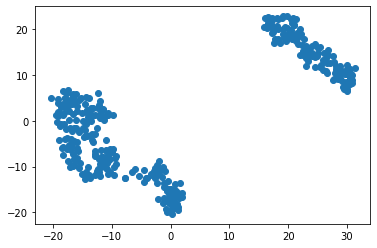

In [4]:
tsne = TSNE(n_components=2)
X_tsne_embedded = tsne.fit_transform(scaled_df.copy())
print(X_tsne_embedded.shape)
plt.scatter(X_tsne_embedded[:, 0], X_tsne_embedded[:, 1])
plt.show()

# UMAP

(342, 2)


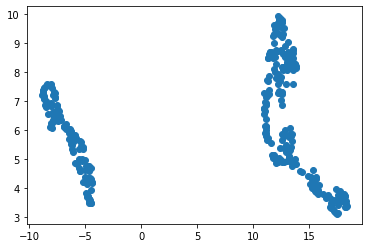

In [5]:
reducer = umap.UMAP(n_components=2)
X_umap_embedded = reducer.fit_transform(scaled_df.copy())
print(X_umap_embedded.shape)
plt.scatter(X_umap_embedded[:, 0], X_umap_embedded[:, 1])
plt.show()

# PCA

(342, 2)


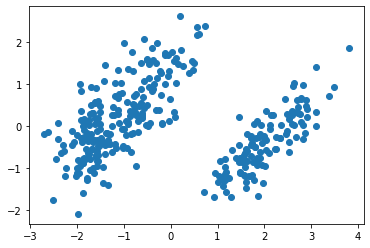

In [6]:
pca = PCA(n_components=2)
X_pca_embedded = pca.fit_transform(scaled_df.copy())
print(X_pca_embedded.shape)
plt.scatter(X_pca_embedded[:, 0], X_pca_embedded[:, 1])
plt.show()

# Finding amount of clusters different metrcics with majority voting

In [13]:
# initialize best amount of clusters for the majority vote.
def majority_n_clusters(models, cluster_range, x):
    x = x.copy()
    labels = [model.predict(x) for model in models]
    inertias = [model.inertia_ for model in models]
    
    # elbow
    kn = KneeLocator(cluster_range, inertias, curve='convex', direction='decreasing')
    amount_clusters_elbow = kn.knee

    # Silhouette Coefficient
    sil_scores = [silhouette_score(x, label) for label in labels]
    sil_scores = list(zip(cluster_range, sil_scores))
    sil_scores = sorted(sil_scores, key=lambda x: x[1], reverse=True)
    amount_clusters_silhouette = sil_scores[0][0]

    # davies_bouldin_score
    db_scores = [davies_bouldin_score(x, label) for label in labels]
    db_scores = list(zip(cluster_range, db_scores))
    db_scores = sorted(db_scores, key=lambda x: x[1], reverse=False)
    amount_clusters_db = db_scores[0][0]

    majority_vote = pd.Series([amount_clusters_elbow, amount_clusters_silhouette, amount_clusters_db]).value_counts().keys()[0]

    return majority_vote

cluster_range = list(range(2, 20))
kmeans_models = [KMeans(n_clusters=i, init='k-means++', random_state=42).fit(scaled_df) for i in cluster_range]
kmean_majority = majority_n_clusters(kmeans_models, cluster_range, scaled_df)
print(f'The majority votes of the amount of clusters is: {kmean_majority}')

The majority votes of the amount of clusters is: 2


### Gaussian Mixture

In [14]:
from itertools import product
from tqdm import tqdm
X = scaled_df.copy()
#X = cluster_df.copy()
co_variance_types = ['full', 'tied', 'diag', 'spherical']
variations = product(range(1, 30), co_variance_types)
model_variants = []
for n_components, co_type in tqdm(variations):
    gm = GaussianMixture(n_components=n_components, covariance_type=co_type, random_state=42)
    gm.fit(X)
    bic_score = gm.bic(X)

    model_variants.append({
        'n_components': n_components,
        'covariance_type': co_type,
        'bic_score': bic_score
    })

116it [00:02, 41.79it/s]


In [15]:
#bic_scores = [model['bic_score'] for model in model_variants]
indexed_modelvariants = list(zip(range(len(model_variants)), model_variants))
indexed_modelvariants = sorted(indexed_modelvariants, key=lambda x: x[1]['bic_score'])

best_model_variation = indexed_modelvariants[0]
for k, v in best_model_variation[1].items():
    print(f'{k}: {v}')

n_components: 4
covariance_type: tied
bic_score: 2501.3566014956077


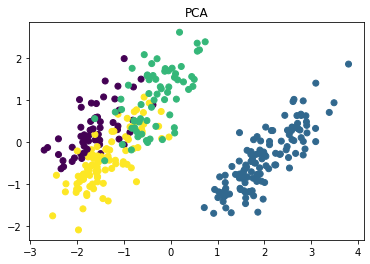

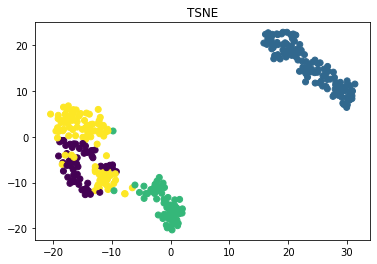

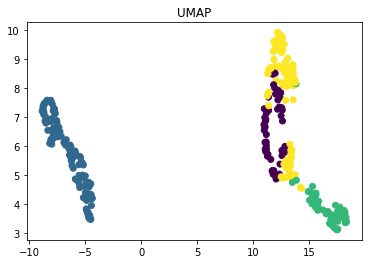

In [16]:
gm = GaussianMixture(n_components=best_model_variation[1]['n_components'], covariance_type=best_model_variation[1]['covariance_type'], random_state=42)
gm.fit(X)
labels = gm.predict(X)
plt.title('PCA')
plt.scatter(X_pca_embedded[:, 0], X_pca_embedded[:, 1], c=labels)
plt.show()
plt.title('TSNE')
plt.scatter(X_tsne_embedded[:, 0], X_tsne_embedded[:, 1], c=labels)
plt.show()
plt.title('UMAP')
plt.scatter(X_umap_embedded[:, 0], X_umap_embedded[:, 1], c=labels)
plt.show()

### DBSCAN

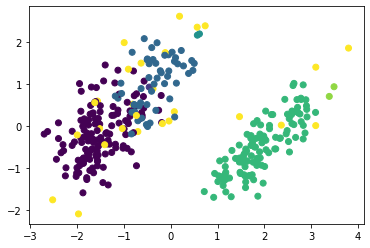

In [17]:
### DBSCAN
X = scaled_df.copy()
model = DBSCAN(eps=0.55, min_samples=2).fit(X)
labels = [label if label != -1 else max(model.labels_) + 1 for label in model.labels_]
plt.scatter(X_pca_embedded[:, 0], X_pca_embedded[:, 1], c=labels)

#### Fixing noise

The noise percentage is: 9.65 %
The noise is put in label -1 so on the plot the purple is the noise.


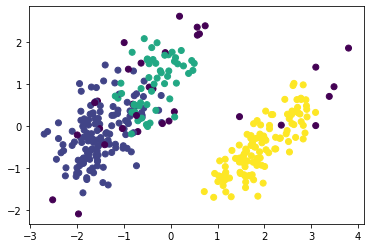

In [19]:
# Observed 3 clusters
observed_clusters = 3

# filter out the main clusters
cluster_sizes = pd.Series(model.labels_).value_counts()
main_clusters = list(cluster_sizes.keys()[:3])

# putting all noise in the same cluster category
denoised_labels = [l if l in main_clusters else -1 for l in model.labels_]

# Get percentage
noise_percentage = denoised_labels.count(-1) / len(denoised_labels)
print(f'The noise percentage is: {round(noise_percentage * 100, 2)} %')

# Plot the new cluster
plt.scatter(X_pca_embedded[:, 0], X_pca_embedded[:, 1], c=denoised_labels)
print(f'The noise is put in label -1 so on the plot the purple is the noise.')